In [2]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
]) # 来自ImageNet的mean和variance

In [4]:
content = load_image("images/content.png", transform, max_size=400)
style = load_image("images/style.png", transform, shape=[content.size(2), content.size(3)])

In [5]:
style.shape

torch.Size([1, 3, 264, 400])

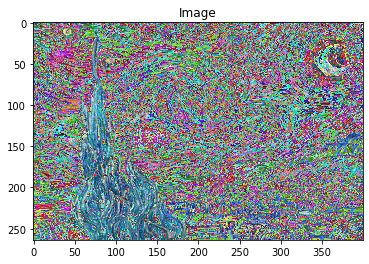

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Image')
# content.shape

In [11]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.1, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [12]:
target_features = vgg(target)

In [12]:
total_step = 10
style_weight = 100.
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
        
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 1 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  

Step [0/10], Content Loss: 0.0000, Style Loss: 641.3631
Step [1/10], Content Loss: 10.2386, Style Loss: 323.7125
Step [2/10], Content Loss: 25.8570, Style Loss: 257.3212
Step [3/10], Content Loss: 14.0689, Style Loss: 226.5482
Step [4/10], Content Loss: 18.5000, Style Loss: 144.6359
Step [5/10], Content Loss: 21.1936, Style Loss: 111.1644
Step [6/10], Content Loss: 22.3910, Style Loss: 87.4605
Step [7/10], Content Loss: 23.0651, Style Loss: 72.9799
Step [8/10], Content Loss: 23.6662, Style Loss: 62.4894
Step [9/10], Content Loss: 23.6506, Style Loss: 54.8641


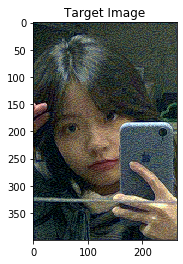

In [13]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
plt.figure()
imshow(img, title='Target Image')

In [10]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

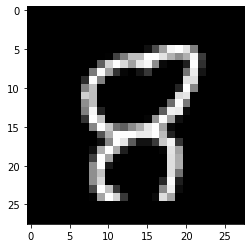

In [22]:
plt.imshow(next(iter(dataloader))[0][4][0], cmap=plt.cm.gray)

In [16]:
image_size = 784

hidden_size = 256
# discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64
# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [23]:

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(dataloader)
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs
        
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 开始优化generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
    

Epoch [0/100], Step [0/1875], d_loss: 0.3287, g_loss: 5.4227, D(x): 0.87, D(G(z)): 0.04
Epoch [0/100], Step [1000/1875], d_loss: 0.0406, g_loss: 4.1445, D(x): 0.98, D(G(z)): 0.02
Epoch [1/100], Step [0/1875], d_loss: 0.3553, g_loss: 6.9208, D(x): 0.85, D(G(z)): 0.01
Epoch [1/100], Step [1000/1875], d_loss: 0.2862, g_loss: 6.9692, D(x): 0.90, D(G(z)): 0.01
Epoch [2/100], Step [0/1875], d_loss: 0.1544, g_loss: 3.6930, D(x): 0.95, D(G(z)): 0.05
Epoch [2/100], Step [1000/1875], d_loss: 0.1057, g_loss: 5.0231, D(x): 0.99, D(G(z)): 0.07
Epoch [3/100], Step [0/1875], d_loss: 0.1945, g_loss: 4.7871, D(x): 0.91, D(G(z)): 0.04
Epoch [3/100], Step [1000/1875], d_loss: 0.0716, g_loss: 5.8402, D(x): 0.96, D(G(z)): 0.02
Epoch [4/100], Step [0/1875], d_loss: 0.1843, g_loss: 4.8263, D(x): 0.92, D(G(z)): 0.06


KeyboardInterrupt: 